In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import math
import os
import seaborn as sns

In [23]:
# read in the cleaned data
listings_2023 = pd.read_csv("data/clean/2023_listings_provisonal.csv")
listings_2022 = pd.read_csv("data/clean/2022_listings_provisonal.csv")
listings_2021 = pd.read_csv("data/clean/2021_listings_provisonal.csv")
listings_2024 = pd.read_csv("data/clean/listings_provisonal.csv")

listings_2024['data_year'] = listings_2024.last_scraped.str[0:4]
listings_2023['data_year'] = listings_2023.last_scraped.str[0:4]
listings_2022['data_year'] = listings_2022.last_scraped.str[0:4]
listings_2021['data_year'] = listings_2021.last_scraped.str[0:4]

all_listings = pd.concat([listings_2024,listings_2023,listings_2022,listings_2021],ignore_index=True)

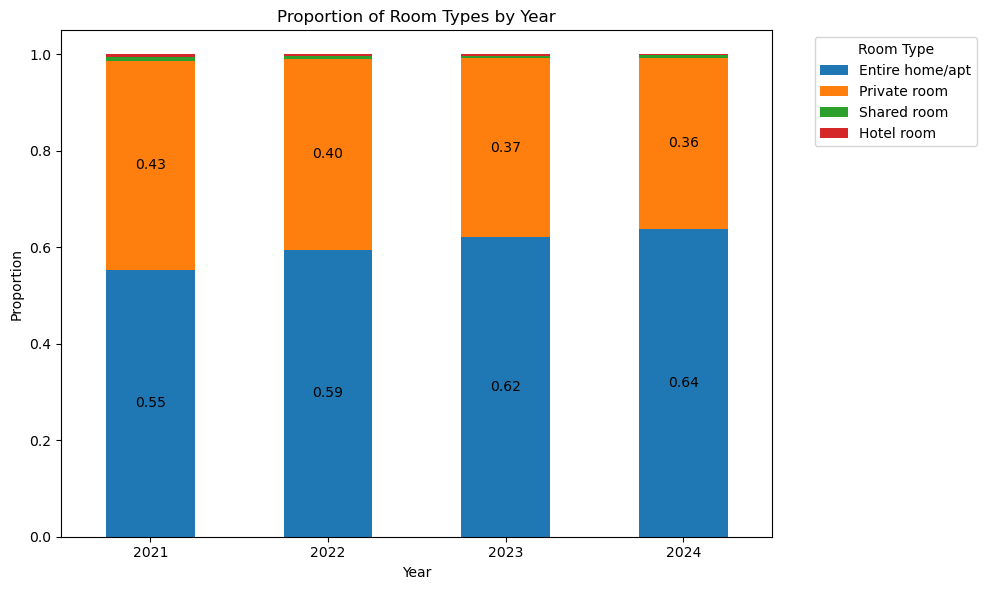

In [24]:
# ChatGPT helped
# Calculate the proportion of each room type per year
room_type_proportions = (
    all_listings.groupby(['data_year', 'room_type'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
)

# Calculate the proportion of each room type per year
room_type_proportions = (
    all_listings.groupby(['data_year', 'room_type'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
)

room_type_proportions=room_type_proportions[['Entire home/apt','Private room','Shared room','Hotel room']]

# Plotting the stacked bar chart
ax = room_type_proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

# Adding labels on top of the bars
for i in range(len(room_type_proportions)):  # Iterate over each bar (year)
    bottom_value = 0  # Track the bottom of the stack
    for col in room_type_proportions.columns:  # Iterate over each room type
        value = room_type_proportions.iloc[i][col]  # Get the proportion value
        if value > 0.03:  # Add label only if the value is non-zero
            ax.text(
                i,  # X-coordinate (bar position)
                bottom_value + value/2,  # Y-coordinate (center of the segment)
                f'{value:.2f}',  # Label text (proportion rounded to 2 decimals)
                ha='center',  # Center horizontally
                va='center',  # Center vertically
                fontsize=10  # Font size
            )
        bottom_value += value  # Update the bottom value for the next stack

plt.title('Proportion of Room Types by Year')
plt.ylabel('Proportion')
plt.xlabel('Year')
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set custom x-axis labels
ax.set_xticks(range(len(room_type_proportions)))
ax.set_xticklabels(['2021','2022','2023','2024'],rotation=0,ha='center')

plt.tight_layout()
plt.savefig('room_type_by_year.png', bbox_inches='tight')  # Save as a PNG file
plt.show()

In [27]:
listings = listings_2024

# create geodataframe
geolistings = gpd.GeoDataFrame(listings,
                               geometry = gpd.points_from_xy(listings.longitude,
                                                             listings.latitude,
                                                             crs ='epsg:4326'))
# read wards shapefile
wards = gpd.read_file("data/London-wards-2018/London-wards-2018_ESRI/London_Ward.shp")

# ensure they are the same CRS
geolistings = geolistings.to_crs(wards.crs)

# Spatial join to find which points fall within each ward
joined_gdf = gpd.sjoin(geolistings, wards, how='inner', predicate='within')

# Calculate average prices and merge onto wards
wards = wards.merge(joined_gdf.groupby('GSS_CODE')['price'].mean(), on='GSS_CODE', how='left')

# rename for accuracy
wards = wards.rename(columns={'price':'avg_price'})

# add a column stating whether the price is above the hotel average of 158
wards['above_158'] = np.where(wards['avg_price'].isna(), None, np.where(wards['avg_price'] > 158, True, False))

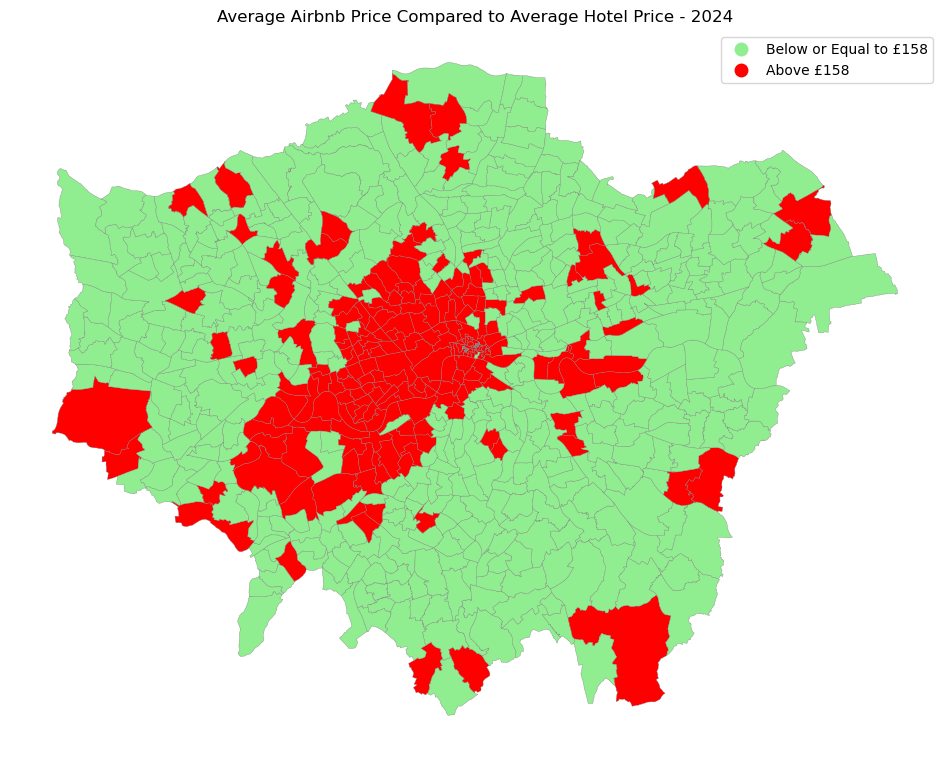

In [28]:
# Plot the map
fig, ax = plt.subplots(figsize=(12, 12))
cmap = ListedColormap(["lightgreen","red"], name='from_list')
wards.plot(column='above_158',
           ax=ax,
           cmap=cmap,
           label='Above 158',
           edgecolor="grey",
           linewidth=0.25,
           legend= True,
           legend_kwds={'labels':['Below or Equal to £158','Above £158']})
wards[wards.avg_price.isna()].plot(facecolor="grey",ax=ax)

# Add title
plt.title('Average Airbnb Price Compared to Average Hotel Price - 2024')
 
ax.axis('off')

# Display the map
plt.savefig('hotel_price_comparison.png', bbox_inches='tight')  # Save as a PNG file
plt.show()

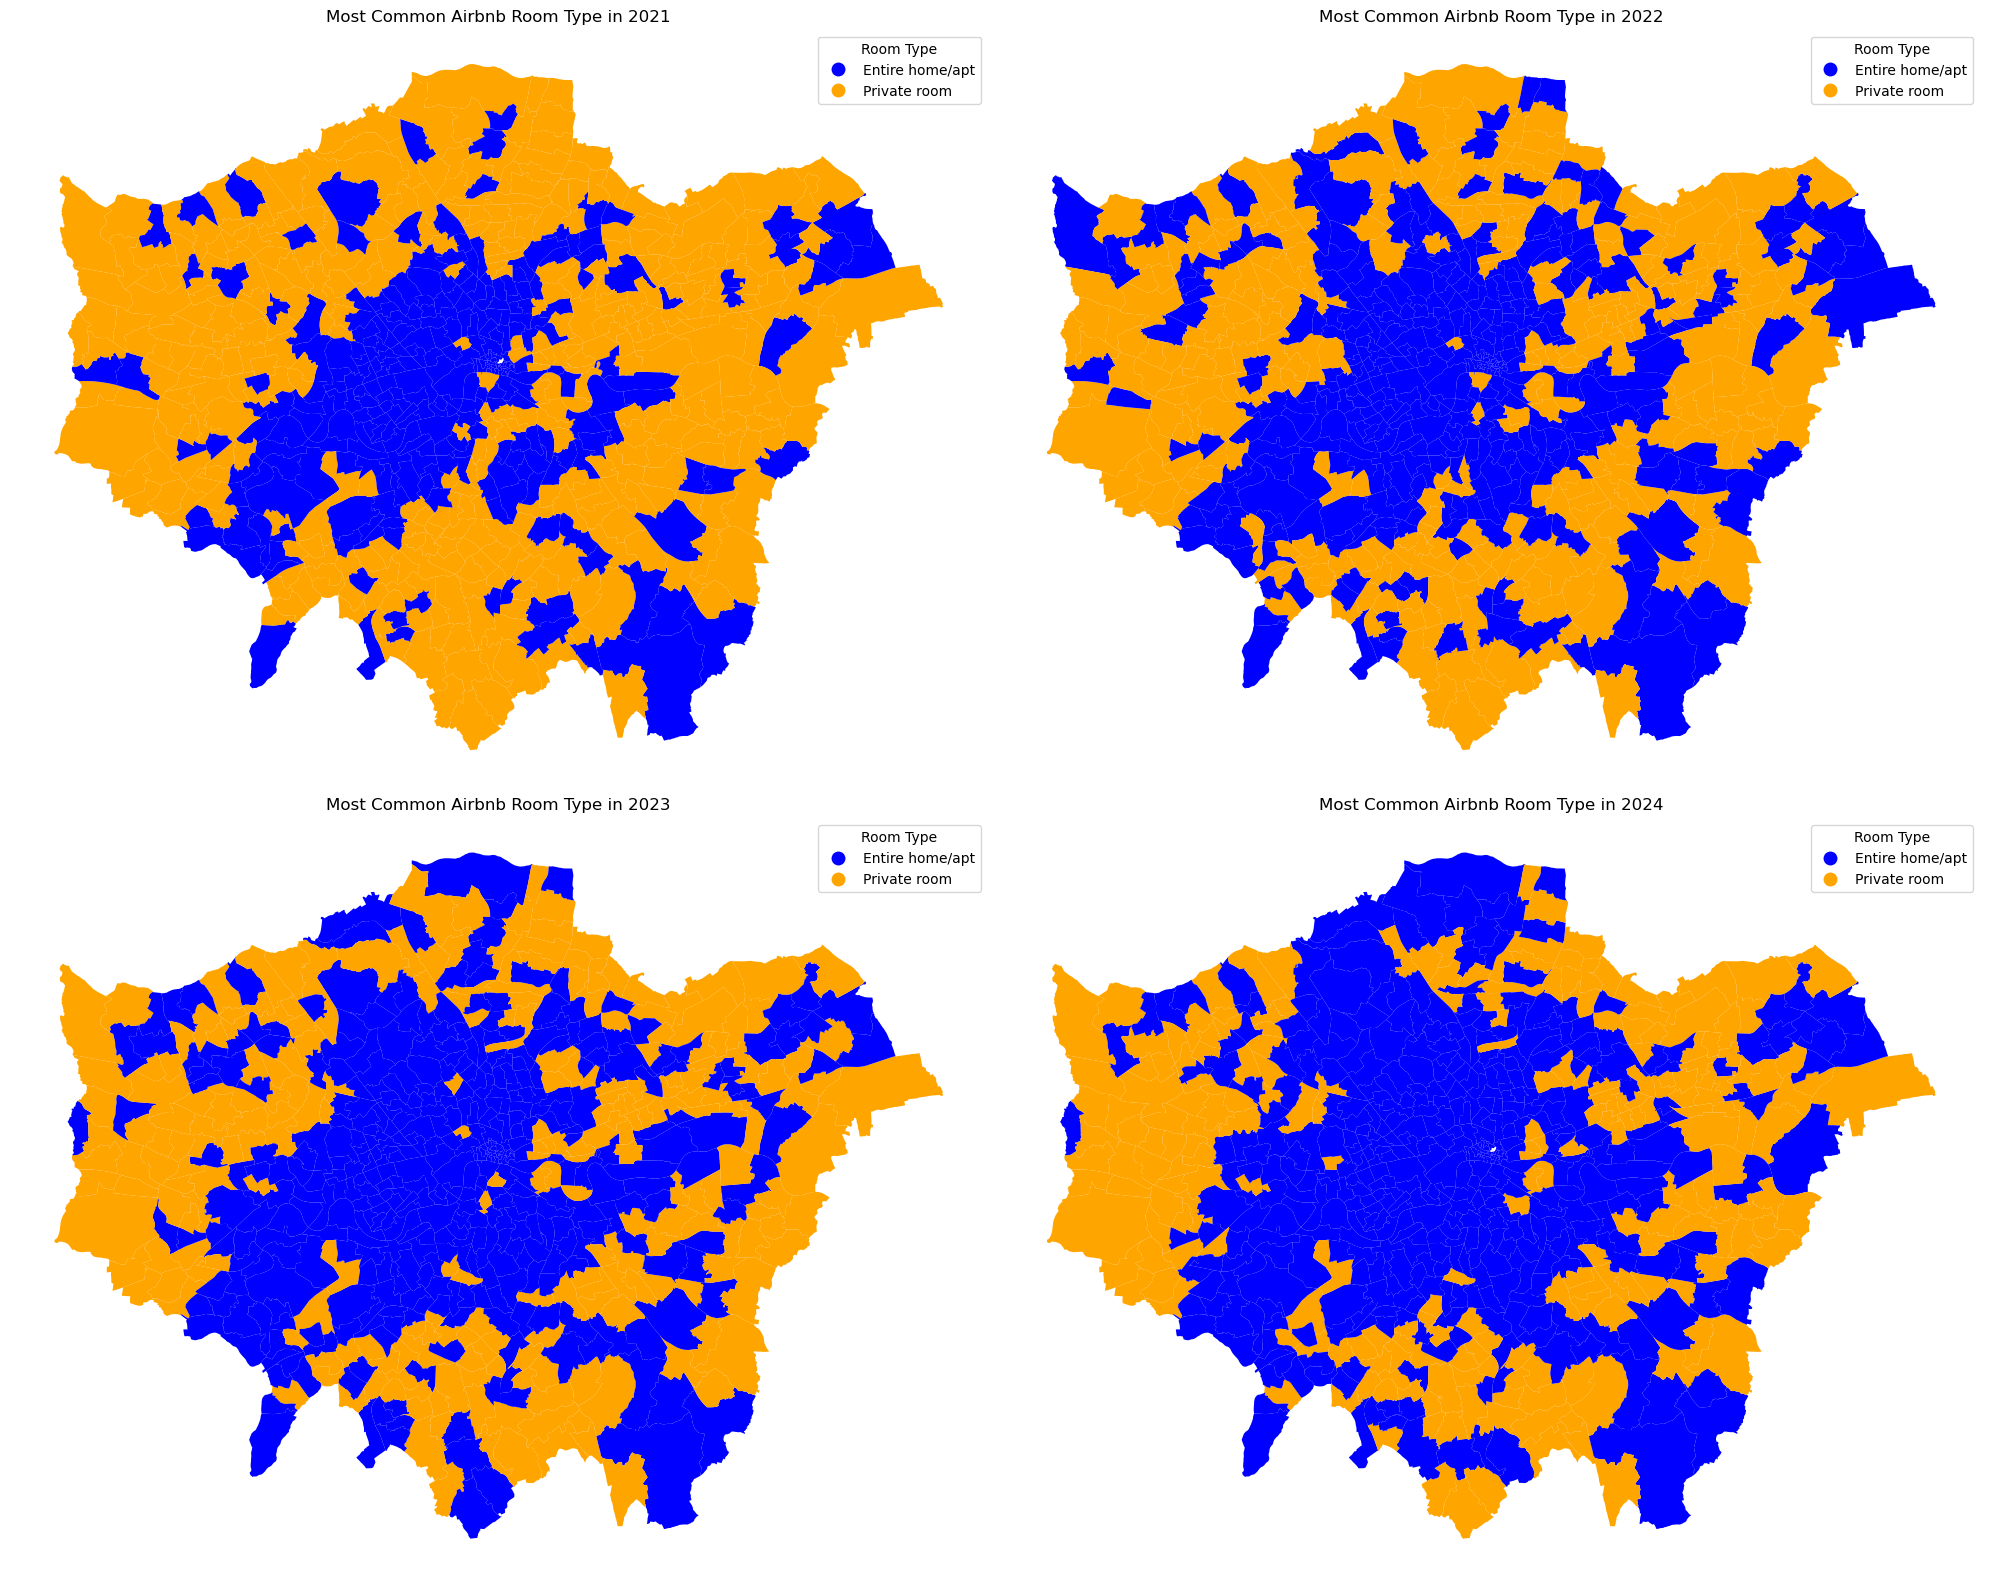

In [83]:
import matplotlib.colors as mcolors

def room_type_map(listings):
    # create geodataframe
    geolistings = gpd.GeoDataFrame(listings,geometry = gpd.points_from_xy(listings.longitude,listings.latitude,crs ='epsg:4326'))
    
    # read wards shapefile
    wards = gpd.read_file("data/London-wards-2018/London-wards-2018_ESRI/London_Ward.shp")
    
    # ensure they are the same CRS
    geolistings = geolistings.to_crs(wards.crs)
    
    # Spatial join to find which points fall within each ward
    joined_gdf = gpd.sjoin(geolistings, wards, how='inner', predicate='within')
    
    # Step 3: Group by ward and room type, and count the number of occurrences
    room_type_counts = joined_gdf.groupby(['GSS_CODE', 'room_type']).size().reset_index(name='count')
    
    # Step 4: Identify the most common room type for each ward
    most_common_room_type = room_type_counts.loc[room_type_counts.groupby('GSS_CODE')['count'].idxmax()]
    
    # Step 5: Merge this result with the wards GeoDataFrame to map it
    wards = wards.merge(most_common_room_type, how='left', left_on='GSS_CODE', right_on='GSS_CODE')

    return wards

# Years to plot
listings_list = [listings_2021,listings_2022,listings_2023,listings_2024]

# Create a plot with 4 subplots (one for each year)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Loop through the years and plot each map
for i, year in enumerate(listings_list):
    ax = axes[i // 2, i % 2]  # Determine the position of the subplot
    wards_map = room_type_map(year)

    #year.head()

    wards_map.plot(column='room_type', cmap=mcolors.ListedColormap(['blue','orange']), 
                ax=ax, legend=True, legend_kwds={'title': 'Room Type'})
    
    # Set the title for each subplot
    ax.set_title(f'Most Common Airbnb Room Type in {i+2021}')
    ax.set_axis_off()  # Optionally turn off the axis for a cleaner look

plt.tight_layout()  # Adjust the layout for better spacing
plt.savefig('room_type_comparison.png', bbox_inches='tight')  # Save as a PNG file
plt.show()

In [4]:
def pie_chart(listings,year):
    # Calculate the percentages of each room type
    room_type_counts = listings['room_type'].value_counts(normalize=True)
    room_type_counts.plot.pie(autopct=lambda pct: '{:1.1f}%'.format(pct) if pct > 1 else '', # remove pct label if less than 1 (they were overlapping)                          
                              startangle=90, # Start angle for better orientation
                              labels = None)
    plt.title(f'Room Type Distribution - {year}')  # Add a title
    plt.ylabel('')  # Remove the y-axis label for better aesthetics
    # plt.savefig('room_type_distribution.png', bbox_inches='tight')  # Save as a PNG file
    plt.show()  # Display the chart"

In [81]:
[color_map.get(rt, 'orange') for rt in wards_map['room_type'].unique()]

['blue', 'orange', 'orange']